<a href="https://colab.research.google.com/github/pipuf/ml_dev_cert/blob/main/Solucion_8_1_1_PRACTICE_Black_Friday_Sales_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning: Linear Regression

## Black Friday Sales Prediction:

We are going to use a dataset of product purchases during a Black Friday (in the US). The main idea is to be able to generate a predictor that allows us to predict the `purchase amount`.

In order to achieve a good predictor we must apply the different concepts that we have been learning:

* `Exploration`
* `Feature Engineering`
* `Modeling`
* `Evaluation`

The dataset here is a sample of the transactions made in a retail store. The store wants to know better the customer `purchase` behaviour against different products. The problem is a `regression problem` where we are trying to predict the dependent variable (the amount of purchase) with the help of the information contained in the other variables.

### You can try differents Scikit-Learn models from [Linear Models](https://scikit-learn.org/1.5/modules/linear_model.html)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

!gdown "1HZ_nk9Q0xp-qbAtXZvDxK5VNVfavt7ph"

data = pd.read_csv("BlackFriday.csv")
data.sample(5)

Downloading...
From: https://drive.google.com/uc?id=1HZ_nk9Q0xp-qbAtXZvDxK5VNVfavt7ph
To: /content/BlackFriday.csv
100% 25.0M/25.0M [00:00<00:00, 40.0MB/s]


,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
333243,1003378,P00042242,M,18-25,4,A,1,0,5,15.0,NaN,3488
513334,1001119,P00025442,M,36-45,1,B,2,1,1,2.0,9.0,19650
198407,1000651,P00063342,M,36-45,7,B,2,0,1,2.0,9.0,11892
186219,1004725,P00057642,M,36-45,5,A,2,0,1,15.0,16.0,15340
517448,1001680,P00146742,M,26-35,20,A,3,1,1,13.0,14.0,4227


In [ ]:
data.describe()


,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.375770e+05,537577.00000,537577.000000,537577.000000,370591.000000,164278.000000,537577.000000
mean,1.002992e+06,8.08271,0.408797,5.295546,9.842144,12.669840,9333.859853
std,1.714393e+03,6.52412,0.491612,3.750701,5.087259,4.124341,4981.022133
min,1.000001e+06,0.00000,0.000000,1.000000,2.000000,3.000000,185.000000
25%,1.001495e+06,2.00000,0.000000,1.000000,5.000000,9.000000,5866.000000
50%,1.003031e+06,7.00000,0.000000,5.000000,9.000000,14.000000,8062.000000
75%,1.004417e+06,14.00000,1.000000,8.000000,15.000000,16.000000,12073.000000
max,1.006040e+06,20.00000,1.000000,18.000000,18.000000,18.000000,23961.000000


In [ ]:
print(data.isnull().sum())
print(data.isnull().mean() * 100)

User_ID                            0
Product_ID                         0
Gender                             0
Age                                0
Occupation                         0
City_Category                      0
Stay_In_Current_City_Years         0
Marital_Status                     0
Product_Category_1                 0
Product_Category_2            166986
Product_Category_3            373299
Purchase                           0
dtype: int64
User_ID                        0.000000
Product_ID                     0.000000
Gender                         0.000000
Age                            0.000000
Occupation                     0.000000
City_Category                  0.000000
Stay_In_Current_City_Years     0.000000
Marital_Status                 0.000000
Product_Category_1             0.000000
Product_Category_2            31.062713
Product_Category_3            69.441029
Purchase                       0.000000
dtype: float64


#🔎 1. Exploration (EDA)

From the sum mary:

#   Target variable: Purchase
*   Mean: ~9333
* Std: ~4981 (wide spread, possibly skewed distribution).
* Range: 185 – 23961

# Features:

* User_ID: Identifier → won’t help prediction, drop it.

* Occupation: Integer (0–20) → categorical but ordinal (job type).

* Marital_Status: Binary (0,1).

* Product_Category_1: Mandatory product category (1–18).

* Product_Category_2 & Product_Category_3: Optional categories → many missing values (170k and 373k missing respectively).

# ⚠️ Issues spotted:

* Missing values in Product_Category_2 and Product_Category_3.

* Some categorical variables are numerical codes, need encoding.

* Target variable has wide variance, possibly needs transformation.




In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

# Target variable
y = data["Purchase"]
# drop IDs since isnot relevant; Purchase since it's target and was moved to Y
#drop Product_Category_3 since missing values percentage is > 65%
x = data.drop(columns=["Purchase", "User_ID", "Product_ID","Product_Category_3"])

# ---- Define column groups ----
numeric_features = []
categorical_onehot = ["City_Category", "Occupation", "Product_Category_1",
                      "Product_Category_2"]   # no order, use one-hot
categorical_age = ["Age"] # is age
categorical_stay = ["Stay_In_Current_City_Years"]  # has order
categorical_binary = ["Gender", "Marital_Status"]  # label/ordinal

# ---- Transformers ----
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),  # fill NaNs with median
    ("scaler", StandardScaler())])

onehot_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy= "constant",fill_value=0)),
    ("encoder", OneHotEncoder( handle_unknown="ignore"))])

age_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[["0-17","18-25","26-35","36-45",
                                            "46-50","51-55","55+"]]))])

stay_transformer = Pipeline(steps=[
    ("encoder", OrdinalEncoder(categories=[["0","1","2","3","4+"]]))])

binary_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OrdinalEncoder())])

# ---- Combine all transformers ----
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("onehot", onehot_transformer, categorical_onehot),
        ("age", age_transformer, categorical_age),
        ("stay", stay_transformer, categorical_stay),
        ("bin", binary_transformer, categorical_binary)])

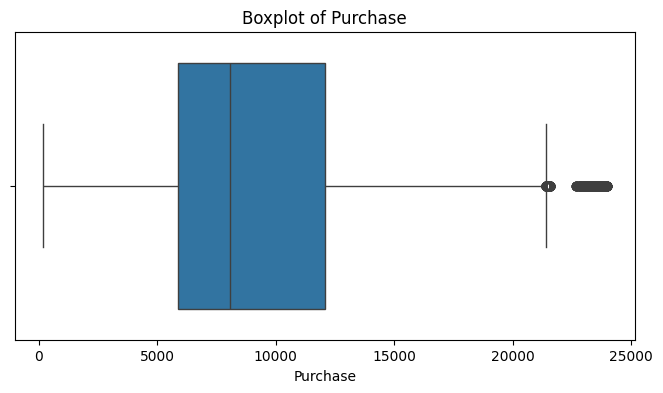

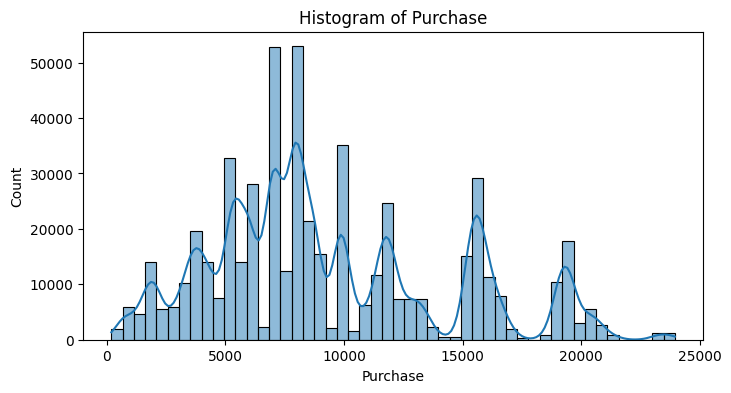

In [ ]:
"""
Evaluate Purchase outliers and normalization need
"""
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.boxplot(x=data["Purchase"])
plt.title("Boxplot of Purchase")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(data["Purchase"], bins=50, kde=True)
plt.title("Histogram of Purchase")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression

model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", LinearRegression())  # you can swap with any model later
])

# ---- Train/test split ----
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# ---- Fit pipeline ----
model.fit(x_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value=0,
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['City_Category',
                                                   'Occupation',
                                                   'Product_Catego...
                                                                                               '18-25',
                                                                                               '26-35',
                                                                                               '36-45',
                                                                                               '46-50',
                                                                                               '51-55',
                                                                                               '55+']]))]),
                                                  ['Age']),
                                                 ('stay',
                                                  Pipeline(steps=[('encoder',
                                                                   OrdinalEncoder(categories=[['0',
                                                                                               '1',
                                                                                               '2',
                                                                                               '3',
                                                                                               '4+']]))]),
                                                  ['Stay_In_Current_City_Years']),
                                                 ('bin',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OrdinalEncoder())]),
                                                  ['Gender',
                                                   'Marital_Status'])])),
                ('regressor', LinearRegression())])

In [ ]:
# ---- Predict ----
y_pred = model.predict(x_test)

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Evaluation
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R²:", r2)


RMSE: 3020.7486057908964
R²: 0.6325578828651788
